In [20]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torcheval.metrics.functional import peak_signal_noise_ratio
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(66)
from PIL import Image

In [21]:
import os

def extract_filepath(folder_root, type):
    lst_paths = []
    folder_dir = os.path.join(folder_root, type)
    for path in os.listdir(folder_dir):
        lst_paths.append(os.path.join(folder_dir, path))
    return lst_paths

train_paths = extract_filepath('./data/Khoa_LHR_image', 'train')
val_paths = extract_filepath('./data/Khoa_LHR_image', 'val')

In [22]:
img = Image.open(train_paths[0]).convert('RGB')
np.array(img).shape

(256, 256, 3)

In [23]:
torch.rand([])

tensor(0.4976)

In [24]:
batch_size = 8
low_img_height = 64
low_img_width = 64

class ImageDataset(Dataset):
    def __init__(self, paths ,low_img_height, low_img_width, is_train):
        super().__init__()
        self.low_img_height = low_img_height
        self.low_img_width = low_img_width
        self.paths = paths
        self.is_train = is_train
        self.resize = transforms.Resize((low_img_width, low_img_height))
    def __len__(self):
        return len(self.paths)
    
    def normalize(self, input_img, tgt_img):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465],
                                 [0.2470, 0.2435, 0.2616])
        ])
        
        input_img = transform(input_img)
        tgt_img = transform(tgt_img)
        return input_img, tgt_img
    
    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image
    def __getitem__(self, index):
        file_path = self.paths[index]
        img = Image.open(file_path).convert('RGB')
        img_input = self.resize(img)
        
        input_img, tgt_img = self.normalize(img_input, img)
        
        if self.is_train:
            input_img, tgt_img = self.random_jitter(input_img, tgt_img)

        return input_img, tgt_img

In [25]:
train_dataset = ImageDataset(train_paths , low_img_height, low_img_width, is_train = True)
val_dataset = ImageDataset(val_paths , low_img_height, low_img_width, is_train = False)

In [26]:
from torch.utils.data import DataLoader

# Tạo DataLoader cho training và validation dataset
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True) 

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


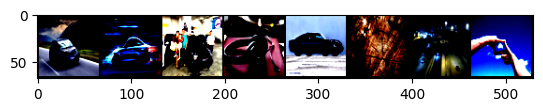

In [27]:
import torchvision
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (input_img, out_img) in enumerate(train_loader, 0):
    imshow(torchvision.utils.make_grid(input_img[:8]))
    break

## Model

### With skip-connection

In [28]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class SR_Unet(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3, tgt_size = 256
    ):
        super(SR_Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((tgt_size, tgt_size),
                                            antialias=True)
        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)

    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x1 = self.in_conv2(x)

        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)

        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)

        x = self.out_conv(x)
        return x

In [29]:
unet_model = SR_Unet().to(device)
img = torch.ones(2, 3, 64, 64).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

In [30]:
model = SR_Unet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [31]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0,
                log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(predictions, labels)
        total_count += 1
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| psnr {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0
            start_time = time.time()

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [32]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_psnr += peak_signal_noise_ratio(predictions, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [33]:
import time

def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    times = []
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        # Training
        train_psnr, train_loss = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch)
        train_psnrs.append(train_psnr.cpu())
        train_losses.append(train_loss)

        # Evaluation
        eval_psnr, eval_loss = evaluate_epoch(
            model, criterion, valid_dataloader, device)
        eval_psnrs.append(eval_psnr.cpu())
        eval_losses.append(eval_loss)

        # Save best model
        if best_psnr_eval < eval_psnr:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            best_psnr_eval = eval_psnr
        times.append(time.time() - epoch_start_time)
        # Print loss, psnr end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [34]:
num_epochs = 2
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'SR_unet_skip_connection'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

KeyboardInterrupt: 

In [ ]:
def predict_and_display(model, inputs, labels, device):
    model.eval()
    inputs, labels = inputs.to(device), labels.to(device)
    predicts = model(inputs)

    inputs, labels, predicts = inputs.cpu().numpy(), labels.cpu().numpy(), predicts.cpu().numpy(),
    plt.figure(figsize=(15, 20))

    # lấy phần tử cuối để hiển thị
    display_list = [inputs[-1].transpose((1, 2, 0)), labels[-1].transpose(
        (1, 2, 0)), predicts[-1].transpose((1, 2, 0))]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    
    plt.show()

In [ ]:
predict_and_display(model, train_loader, device)